In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
#                 if not meta.query('@va == visual_area and @dk == datakey').empty])
# # Neural data
# NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
#                       response_type=response_type, trial_epoch=trial_epoch,
#                       responsive_test=responsive_test, 
#                       responsive_thr=responsive_thr)
# if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
#     NDATA0['experiment'] = experiment 

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [7]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = False
overlap_thr= 0.0 #0.0

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)

## Output dirs

In [8]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)) or match_rfs:
    curr_dst_dir = os.path.join(basedir, 'controls')
else:
    curr_dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00
dff-ROC__stimulus__overlap0.00__C1.00


## Load

In [15]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
iterdf, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=None,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]
    

(Li) Found 9 paths
(Lm) Found 9 paths
(V1) Found 10 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths


In [16]:
class_name

'morphlevel'

In [17]:
grouper = ['visual_area', 'condition', 'iteration']
mean_df0 = dec.average_within_iterations_by_ncells(iterdf, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 

if test_type is not None:
    score_table = mean_df0[ (mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'novel'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'novel'], columns='n_cells')
else:
    score_table = mean_df0[(mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells'])\
            .mean()['heldout_test_score'].reset_index().pivot_table(index='visual_area', columns='n_cells')
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

['visual_area', 'condition', 'iteration', 'n_cells', 'novel']
EXP: blobs (class=morphlevel): dff-ROC__stimulus__overlap0.00__C1.00


heldout_test_score                                          \
n_cells                          1         2         4         8         16    
visual_area novel                                                              
Li          False           0.525020  0.544831  0.570656  0.598471  0.615770   
            True            0.523391  0.537498  0.556059  0.582581  0.598081   
Lm          False           0.534767  0.545600  0.561500  0.589667  0.614267   
            True            0.517668  0.522439  0.531990  0.541983  0.552917   
V1          False           0.542438  0.560095  0.589200  0.619867  0.653233   
            True            0.520938  0.532741  0.551360  0.564369  0.583514   

                                                                     
n_cells                 32        64        96        128       256  
visual_area novel                                                    
Li          False  0.645717  0.724856  0.772612  0.808873       NaN  
            True   0.623237  0.674318  0.707698  0.728900       NaN  
Lm          False  0.640900  0.702533  0.743033  0.776400       NaN  
            True   0.563745  0.595391  0.614047  0.631041       NaN  
V1          False  0.694700  0.768233  0.815267  0.844700  0.899833  
            True   0.606193  0.648800  0.678997  0.698538  0.737433

In [18]:
max_ncells=128 # 96 if match_Rfs
special_cases = [169, 120, 46] # 169, test; 120: for match_rfs; 46: for testing overlap_thr

n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells\
               and s not in special_cases]
xlabels = [1, 32, 96, max_ncells]
grouper = ['visual_area', 'condition', 'iteration']

mean_df = mean_df0[mean_df0['n_cells'].isin(sample_sizes)]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

novel: [False  True]
conditions: ['data' 'shuffled']


In [19]:
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)

128


<IPython.core.display.Javascript object>


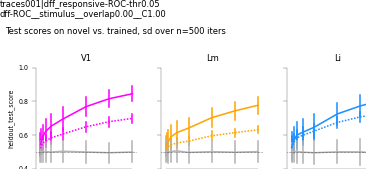

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 trained_v_novel_byncells__dff-ROC__stimulus__overlap0.00__C1.00


In [20]:
plotd = mean_df[mean_df['n_cells']<=max_ncells].copy()
plotd['novel_labels'] = None
plotd.loc[plotd['novel'], 'novel_labels'] = 'novel'
plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

%matplotlib notebook
metric='heldout_test_score'
if analysis_type=='by_ncells':
    fig, axn = pl.subplots(1,3, figsize=(6.5, 3), sharex=True, sharey=True)
    for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
        ai = visual_areas.index(va)
        ax=axn[ai]; ax.set_title(va);
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='data'], ax=ax,
                style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
                    color=area_colors[va])
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='shuffled'],ax=ax,
                color=[0.7]*3, ci='sd', err_style='bars', label='shuffled', 
                    linestyle='-')
        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.07, right=0.8, bottom=0.25, top=0.7,
                      wspace=0.2)
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_box_aspect(1)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

fig.text(0.01, 0.85, 'Test scores on novel vs. trained, sd over n=%i iters' % n_iters,
        fontsize=8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'trained_v_novel_byncells__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
figname = 'trained_v_novel_byncells__%s' % aggr_id
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(curr_dst_dir, figname)

In [21]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00'

<IPython.core.display.Javascript object>


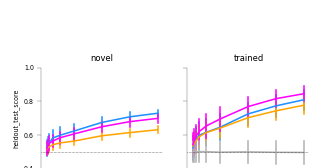

In [22]:

%matplotlib notebook
metric='heldout_test_score'
if analysis_type=='by_ncells':
    fig, axn = pl.subplots(1,2, figsize=(5.5, 3), sharex=True, sharey=True)
    for ai, (cond, df_) in enumerate(plotd.groupby(['novel_labels'])):
        ax=axn[ai]; ax.set_title(cond);
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='data'], ax=ax,
                    ci='sd', err_style='bars',
                    hue='visual_area', palette=area_colors)
        sns.lineplot(x='n_cells', y=metric, ax=ax,
                    data=df_[df_.condition=='shuffled'],
                    color=[0.7]*3, ci='sd', err_style='bars', label='shuffled', 
                    linestyle='-')
        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.75, bottom=0.25, top=0.7,
                      wspace=0.2)
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

In [23]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00'

#### Discrimination performance (train config = test config)

<IPython.core.display.Javascript object>


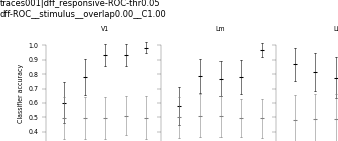

/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 trainconfigs__dff-ROC__stimulus__overlap0.00__C1.00


In [24]:
#max_ncells = 96
curr_ncells=max_ncells

traind = iterdf[~(iterdf.novel) & (iterdf['n_cells']==curr_ncells)].copy()

fg = sns.FacetGrid(traind, col='visual_area', col_order=visual_areas, 
                   height=2.5, aspect=0.8)
fg.map(sns.pointplot, 'train_transform', 'heldout_test_score', 'condition', 
      palette={'data': 'k', 'shuffled': 'gray'}, markers='_', ci='sd',
       capsize=0.1, scale=0.5, errwidth=0.5, join=False)
fg.set_titles(col_template="{col_name}")

sns.despine(bottom=True, offset=8, trim=True)
for ai,ax in enumerate(fg.axes.flat):
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticklabels([int(s) for s in sorted(traind['train_transform'].unique())])
    if ai==0:
        ax.set_ylabel('Classifier accuracy')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.12, bottom=0.2, right=0.86, top=0.8)
pplot.label_figure(fg.fig, '%s\n%s' % (data_id, aggr_id))

figname = 'trainconfigs__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Trained vs Novel, by training condition

<IPython.core.display.Javascript object>


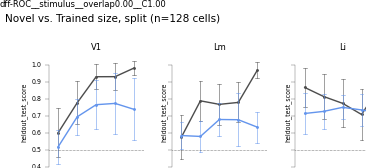

In [25]:
plotd = iterdf[iterdf['n_cells']==max_ncells].copy()
plotd['novel_labels'] = None
plotd.loc[plotd['novel'], 'novel_labels'] = 'novel'
plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}

metric = 'heldout_test_score'
fig, axn = pl.subplots(1,3, figsize=(6.5, 3), sharex=True, sharey=True)
for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va)
    sns.pointplot(x='train_transform', y=metric, data=df_[df_.condition=='data'], 
            ax=ax, scale=0.5, palette=cond_colors, hue='novel_labels',
            ci='sd',capsize=0.2, errwidth=0.5, markers='.')
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75,
                  wspace=0.3)
sns.despine(trim=True)
pplot.label_figure(fig, aggr_id)
fig.text(0.01, 0.9, 'Novel vs. Trained size, split (n=%i cells)' % max_ncells)

figname = 'trained_v_novel_transforms__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

## Generalization score

In [26]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [27]:
metric = 'heldout_test_score'
pass_list=[]
for (va, nc), g in mean_df.groupby(['visual_area', 'n_cells']):
    traindf = g[~(g.novel)].sort_values(by='iteration')
    # Get values for all iterations at current NCELLS & COND (500 iters):
    ddf = traindf[traindf.condition=='data'][metric].reset_index(drop=True)
    ddf_s = traindf[traindf.condition=='shuffled'][metric].reset_index(drop=True)
    # Get indices were data > shuffled
    pass_ixs = ddf[ddf>ddf_s].index.to_numpy()
    pass_list.append(g[g.iteration.isin(pass_ixs)])

In [28]:
passdf = pd.concat(pass_list, axis=0)

In [29]:
metric='heldout_test_score'
byiter_novel = dec.generalization_score_by_iter(passdf, max_ncells=max_ncells)

In [30]:
gen_df = byiter_novel[(byiter_novel['n_cells']==max_ncells)].drop_duplicates()
gen_df.shape

(1500, 15)

<IPython.core.display.Javascript object>


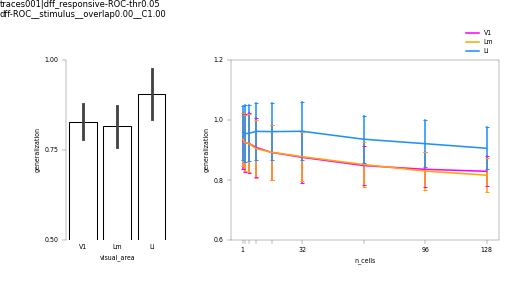

In [31]:
metric='generalization'
multi_comp_test='fdr_bh'
import matplotlib.gridspec as gridspec
fig = pl.figure(figsize=(7,4))
gs = gridspec.GridSpec(1,3) # figsize=(6,3))

ax=fig.add_subplot(gs[0])
sns.barplot(x='visual_area', y=metric, 
            data=gen_df, ax=ax, ci='sd',
            order=visual_areas, edgecolor=('k', 'k', 'k'), facecolor='none')
ax.set_yticks(np.linspace(0.5, 1, 3))
ax.set_ylim([0.5,1])
sns.despine(bottom=True, ax=ax, trim=True)
ax.tick_params(which='both', axis='x', size=0)

ax=fig.add_subplot(gs[1:])
sns.lineplot(x='n_cells', y=metric, data=byiter_novel, ax=ax, 
             hue='visual_area', ci='sd',err_style='bars', err_kws={'capsize':2},
             palette=area_colors, hue_order=visual_areas)

ax.set_yticks(np.linspace(0.6, 1.2, 4))
ax.set_ylim([0.6,1.2])
ax.set_xticks(sample_sizes)
ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])

    
# legend
ax.legend(bbox_to_anchor=(1., 1.), loc='lower right', frameon=False,
          title='', markerscale=0.5, fontsize=6)
pl.subplots_adjust(wspace=0.6, right=0.95, top=0.8, bottom=0.2)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))


In [32]:
gen_df.groupby('visual_area')['generalization'].describe()

,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,500.0,0.905746,0.069298,0.728745,0.856902,0.901574,0.947368,1.182186
Lm,500.0,0.815971,0.057516,0.658046,0.776912,0.810899,0.849603,1.022232
V1,500.0,0.829009,0.049756,0.713978,0.794586,0.827586,0.858836,0.985110


#### Calculate "generalization score"

In [33]:
# Calculate difference
byiter_data = mean_df[(mean_df['n_cells']<=max_ncells)
                     & (mean_df['condition']=='data')]
cols = ['visual_area', 'n_cells', 'iteration', 'train_transform', 'test_transform']
diffdf = byiter_data[cols].copy().reset_index(drop=True).drop_duplicates()
diffdf = diffdf.sort_values(by=['iteration', 'visual_area'])

byiter_data = byiter_data.sort_values(by=['iteration', 'visual_area'])
true_diffs = byiter_data[(~byiter_data.novel)]['heldout_test_score'].values\
            - byiter_data[(byiter_data.novel)]['heldout_test_score'].values
diffdf['difference'] = true_diffs

In [34]:
# Shuffle
currd = byiter_data[byiter_data['n_cells']==max_ncells].copy()
d_list = []
for i in range(n_iters):
    d_=[]
    for va, all_vals in currd.groupby(['visual_area']):
        half_vs = all_vals['heldout_test_score'].sample(n=n_iters, replace=False)
        unused = [v for v in all_vals.index if v not in half_vs.index]
        other_vs = all_vals.loc[unused, 'heldout_test_score'].sample(n_iters)
        diff_ = np.mean(half_vs.values - other_vs.values)
        df_ = pd.DataFrame({diff_}, index=[i], columns=[va])
        d_.append(df_)
    d_list.append(pd.concat(d_, axis=1))

shuff_diff = pd.concat(d_list, axis=0).stack().reset_index()\
                .rename(columns={0: 'difference', 'level_1': 'visual_area'})
shuff_diff['condition'] = 'shuffled'
shuff_diff = shuff_diff.drop('level_0', 1)

In [35]:
# combine
true_diff = pd.concat([pd.DataFrame({'difference': d['difference'].values}, 
                                     index=[va]*n_iters) \
    for va, d in diffdf[diffdf['n_cells']==max_ncells].groupby('visual_area')], 
                       axis=0) #.reset_index(drop=True)
true_diff['condition'] = 'data'
true_diff['visual_area'] = true_diff.index.tolist()
true_diff = true_diff.reset_index(drop=True)
diffs = pd.concat([true_diff, shuff_diff], axis=0)

<IPython.core.display.Javascript object>


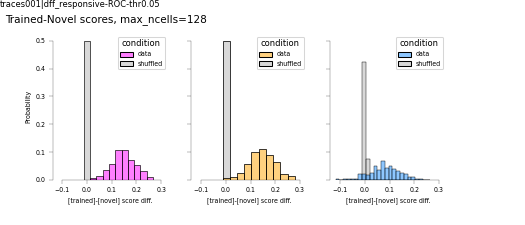

In [36]:
fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)
for vi, (va, df_) in enumerate(diffs.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x='difference', hue='condition', data=df_, ax=ax, alpha=0.5,
                palette={'data': area_colors[va], 'shuffled': [0.7]*3},
                 stat='probability', legend=True)
#                 cumulative=True, element='poly', fill=False)
    #true_mean = diffdf[diffdf.visual_area==va]['difference'].mean()
    #ax.axvline(x=true_mean, color=area_colors[va])
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85)
for ax in axn:
    ax.set_xlabel('[trained]-[novel] score diff.')
    #ax.legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False, fontsize=6,)
    #          title='')
sns.despine(trim=True)

fig.text(0.01, 0.9, 'Trained-Novel scores, max_ncells=%i' % max_ncells)

pplot.label_figure(fig, data_id)

figname = 'hist_trained_vs_novel__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [37]:
import scipy.stats as spstats

In [38]:
data = [diffdf.loc[ids, 'difference'].values \
        for ids in diffdf.groupby('visual_area').groups.values()]

In [39]:
H, p = spstats.kruskal(*data)
H, p

(1022.2714023609312, 1.038928053918243e-222)

In [40]:
# import scikit_posthocs as skp
# skp.post_(df, val_col='SepalWidth', group_col='Species', p_adjust = 'holm')

<IPython.core.display.Javascript object>


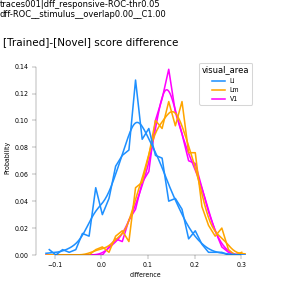

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 dist_trained_vs_novel_difference__dff-ROC__stimulus__overlap0.00__C1.00


In [41]:
fig, ax = pl.subplots(figsize=(4,4))
sns.histplot(x='difference', hue='visual_area', data=diffs[diffs.condition=='data'],
             ax=ax,
            cumulative=False, element='poly', fill=False, kde=True,
            palette=area_colors, stat='probability', common_norm=False)
# sns.histplot(x='difference', hue='visual_area', data=diffs[diffs.condition=='shuffled'],
#              ax=ax, line_kws={'linestyle': ':'},
#             cumulative=True, element='poly', fill=False,
#             palette=area_colors, stat='probability', common_norm=False)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
sns.despine(trim=True)
fig.text(0.01, 0.85, '[Trained]-[Novel] score difference')
pl.subplots_adjust(bottom=0.15, top=0.8, left=0.12, right=0.85)
#figname='cumdist_trained_vs_novel_difference__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
figname='dist_trained_vs_novel_difference__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

In [42]:
diffs.groupby(['visual_area', 'condition']).count()

difference
visual_area condition            
Li          data              500
            shuffled          500
Lm          data              500
            shuffled          500
V1          data              500
            shuffled          500

In [240]:
pg.kruskal(data=plotd, dv='difference', between='visual_area')

,Source,ddof1,H,p-unc
Kruskal,visual_area,2,364.44635,7.269099e-80


<IPython.core.display.Javascript object>


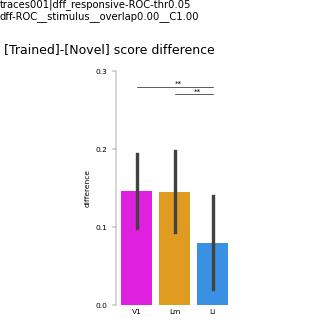

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 bar_trained_vs_novel_difference__dff-ROC__stimulus__overlap0.00__C1.00


In [243]:
plotd = diffs[diffs.condition=='data'].copy()
posthoc='fdr_bh'
ylim=0.3
fig, ax = pl.subplots(figsize=(4,4))
sns.barplot(x='visual_area', y='difference', data=plotd,
             ax=ax, palette=area_colors, order=visual_areas, ci='sd')

sts = pg.pairwise_ttests(data=plotd, dv='difference', between='visual_area',
                         parametric=False, padjust=posthoc, effsize='eta-square')  
pplot.annotate_multicomp_by_area(ax, sts, y_loc=0.27, offset=0.01)

ax.set_box_aspect(2)
ax.set_ylim([0, ylim])
ax.set_yticks(np.linspace(0, ylim, 4))
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
fig.text(0.01, 0.85, '[Trained]-[Novel] score difference')
pl.subplots_adjust(bottom=0.15, top=0.8, left=0.12, right=0.85)

figname='bar_trained_vs_novel_difference__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)


In [148]:
all_vals =  diffs[diffs.condition=='data']
# li_vals = all_vals[all_vals.visual_area=='Li']['difference']
# lm_vals = all_vals[all_vals.visual_area=='Lm']['difference']
# v1_vals = all_vals[all_vals.visual_area=='V1']['difference']


In [194]:
import itertools
import pingouin as pg


<IPython.core.display.Javascript object>


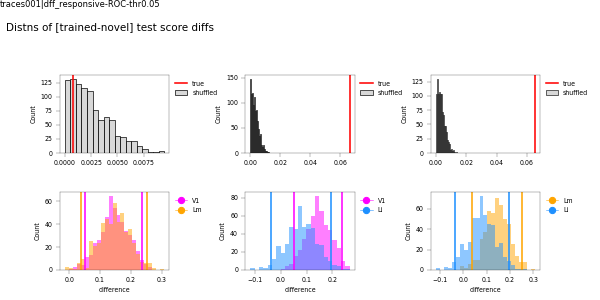

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 shuffle_test_trained-v-novel


In [234]:
n_shuff=1000
p_vals = []
metric='difference'
# v1='Lm'
# v2='Li'
v_combos = list(itertools.combinations(visual_areas, 2))

fig, axn = pl.subplots(2, len(v_combos), figsize=(8,4))

for ai, (v1, v2) in enumerate(v_combos):
    v_list = [v1, v2]
    a_ = all_vals[all_vals.visual_area==v1][metric]
    b_ = all_vals[all_vals.visual_area==v2][metric]
    true_ = abs(a_.mean() - b_.mean())

    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(n_shuff):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:500])
        v = np.mean(combined_[500:])
        diff_s = abs(i-v)
        shuff_.append(diff_s)
    shuff = np.array(shuff_)
    pv_ = len(np.where(shuff>true_)[0])/n_shuff
    p_vals.append(pd.Series({'v1': v1, 'v2': v2, 'p_val': pv_}))
    
    ax=axn[0, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    ax=axn[1, ai]
    c1= area_colors[v1]
    c2 = c2=area_colors[v2]
    sns.histplot(x=metric, hue='visual_area', ax=ax,
                 data=all_vals[all_vals.visual_area.isin(v_list)], 
                 palette={v1:c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(all_vals[all_vals.visual_area==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(all_vals[all_vals.visual_area==v2][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.75, wspace=0.7, hspace=0.5)
fig.text(0.01, 0.9, "Distns of [trained-novel] test score diffs")

pplot.label_figure(fig, data_id)

figname = 'shuffle_test_trained-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


In [200]:
pd.concat(p_vals, axis=1).T


,v1,v2,p_val
0,V1,Lm,0.823
1,V1,Li,0.0
2,Lm,Li,0.0


In [195]:
pg.multicomp(p_vals, alpha=0.05, method='bonf')

(array([False,  True,  True]), array([1., 0., 0.]))

In [205]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00'

## Check if NOVEL v TRAINED diff

In [132]:
# df_ = mean_df[(mean_df['n_cells']==max_ncells) 
#             & (mean_df['condition']=='data')].copy()
# df_.groupby(['visual_area', 'novel']).count()

# df_ = mean_df[(mean_df['n_cells']==max_ncells) 
#             & ~(mean_df['novel'])].copy().reset_index(drop=True)
# df_.groupby(['visual_area', 'condition']).count()

df_ = mean_df[(mean_df['n_cells']==max_ncells) 
            & (mean_df['condition']=='data')].copy().reset_index(drop=True)
df_.groupby(['visual_area', 'novel']).count()

condition  iteration  n_cells  fit_time  score_time  \
visual_area novel                                                        
Li          False        500        500      500       500         500   
            True         500        500      500       500         500   
Lm          False        500        500      500       500         500   
            True         500        500      500       500         500   
V1          False        500        500      500       500         500   
            True         500        500      500       500         500   

                   test_score  train_score  heldout_test_score    C  randi  \
visual_area novel                                                            
Li          False         500          500                 500  500    500   
            True          500          500                 500  500    500   
Lm          False         500          500                 500  500    500   
            True          500          500                 500  500    500   
V1          False         500          500                 500  500    500   
            True          500          500                 500  500    500   

                   train_transform  test_transform  n_trials  randi_cells  \
visual_area novel                                                           
Li          False              500             500       500          500   
            True               500             500       500          500   
Lm          False              500             500       500          500   
            True               500             500       500          500   
V1          False              500             500       500          500   
            True               500             500       500          500   

                   intact  overlap_thr  
visual_area novel                       
Li          False     500          500  
            True      500          500  
Lm          False     500          500  
            True      500          500  
V1          False     500          500  
            True      500          500

<IPython.core.display.Javascript object>


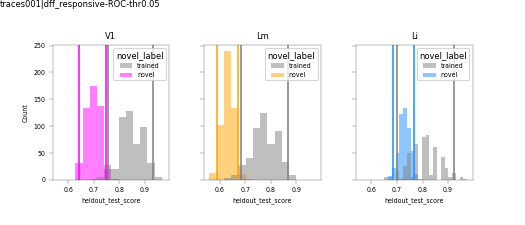

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 distns_95CI_test_trained-v-novel


In [233]:
metric='heldout_test_score'
# c1='cornflowerblue'
# c2 = [0.8]*3
v1='novel'
v2='trained'
df_['novel_label'] = [v1 if v else v2 for v in df_['novel'].values]
fig, axn = pl.subplots(1,3, figsize=(7,3), sharex=True, sharey=True)

for va, vg in df_.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    c1 = area_colors[va]
    c2 = [0.5]*3
#     a_ = vg[(vg.novel)][metric]
#     b_ = vg[~(vg.novel)][metric]
#     true_ = b_.mean() - a_.mean()
#     combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
#     shuff_=[]
#     for n in range(1000):
#         np.random.shuffle(combined_)
#         i = np.mean(combined_[0:500])
#         v = np.mean(combined_[500:])
#         ds_ = abs(i-v)
#         shuff_.append(ds_)
#     shuff = np.array(shuff_)
#     sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
#     ax.axvline(x=true_, color='r', label='true')
#     print(len(np.where(shuff>true_)[0])/2000.)
#     pl.subplots_adjust(bottom=0.2, right=0.8)

    sns.histplot(x='heldout_test_score', hue='novel_label', data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)
#     ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.novel][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(vg[~(vg.novel)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    ax.set_title(va)
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3)
pplot.label_figure(fig, data_id)

figname = 'distns_95CI_test_trained-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


In [131]:
len(np.where(shuff<true_)[0])/1000.


1.667

In [357]:
import pingouin as pg

In [375]:
plotd = df_[['visual_area', 'novel', 'heldout_test_score', 'iteration']].copy().reset_index(drop=True)
plotd['subject'] = ['%s_%i' % (va, ni) for va, ni in plotd[['visual_area', 'iteration']].values]
plotd.head()

,visual_area,novel,heldout_test_score,iteration,subject
0,Li,False,0.825000,0,Li_0
1,Li,True,0.713158,0,Li_0
2,Li,False,0.900000,1,Li_1
3,Li,True,0.755263,1,Li_1
4,Li,False,0.650000,2,Li_2


In [372]:
from pingouin import mixed_anova, read_dataset
df = read_dataset('mixed_anova')
df

,Scores,Time,Group,Subject
0,5.971435,August,Control,0
1,4.309024,August,Control,1
2,6.932707,August,Control,2
3,5.187348,August,Control,3
4,4.779411,August,Control,4
...,...,...,...,...
175,6.176981,June,Meditation,55
176,8.523692,June,Meditation,56
177,6.522273,June,Meditation,57
178,4.990568,June,Meditation,58


In [378]:
pg.mixed_anova(data=plotd, dv='heldout_test_score', within='novel', 
              between='visual_area', subject='subject', correction=True)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,visual_area,2.954740,2,1497,1.477370,822.690953,9.019487e-242,0.52361,NaN
1,novel,11.500601,1,1497,11.500601,8041.647076,0.000000e+00,0.84306,1.0
2,Interaction,0.721420,2,1497,0.360710,252.221841,3.962799e-95,0.25204,NaN


<IPython.core.display.Javascript object>


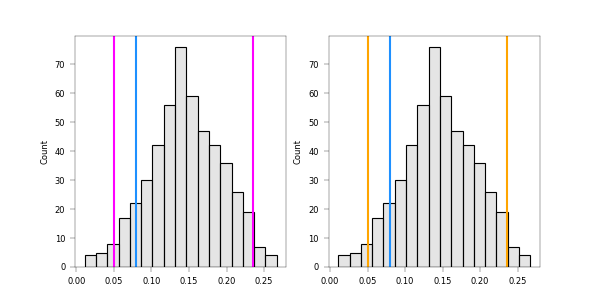

In [229]:
all_vals =  diffs[diffs.condition=='data']
li_vals = all_vals[all_vals.visual_area=='Li']['difference'].values
lm_vals = all_vals[all_vals.visual_area=='Lm']['difference'].values
v1_vals = all_vals[all_vals.visual_area=='V1']['difference'].values

fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
compare_v = 'V1'
for ax, compare_v in zip(axn.flat, ['V1', 'Lm']):
    compare_vals = all_vals[all_vals.visual_area==compare_v]['difference'].values
    sns.histplot(v1_vals, color=[0.8]*3, alpha=0.5, ax=ax)
    c_lo, c_hi = hutils.get_empirical_ci(v1_vals, ci=0.95)
    ax.axvline(x=c_lo, color=area_colors[compare_v])
    ax.axvline(x=c_hi, color=area_colors[compare_v])

    # # sns.histplot(x='trained_minus_novel', data=plotd[plotd['rfs']=='matched'], ax=ax)
    mean_v = np.mean(li_vals)
    ax.axvline(x=mean_v, color=area_colors['Li'])

In [168]:
diffs[diffs.condition=='data'].groupby('visual_area').describe()

difference                                                    \
                 count      mean       std       min       25%       50%   
visual_area                                                                
Li               500.0  0.064928  0.056877 -0.093421  0.023684  0.068421   
Lm               500.0  0.065104  0.055064 -0.100862  0.028664  0.064080   
V1               500.0  0.140040  0.043500 -0.012356  0.113937  0.139655   

                                 
                  75%       max  
visual_area                      
Li           0.106579  0.198684  
Lm           0.101509  0.242816  
V1           0.169325  0.262356

## Split generalization score by TRAIN vs TEST

In [169]:
# results.loc[results['heldout_test_score']==0, 'heldout_test_score'] = 0.000000000001
metric='heldout_test_score'
drop_cols = ['fit_time', 'score_time', 'train_score', 'test_score']
cols = [c for c in iterdf.columns if c not in drop_cols]
data_df = iterdf[(iterdf.condition=='data')][cols].copy().reset_index(drop=True)

data_df['generalization'] = None
data_df['train_test_diff'] = None
for tr, g in data_df.groupby(['train_transform']):
    train_vals = g[g.train_transform==g.test_transform][metric].values
    for te, gg in g.groupby(['test_transform']):
        data_df.loc[gg.index, 'generalization']= gg[metric]/train_vals
        data_df.loc[gg.index, 'train_test_diff'] = tr-te
data_df['generalization'] = data_df['generalization'].astype(float)
data_df['train_test_abs'] = np.abs(data_df['train_test_diff']).astype(float)
data_df['train_test_diff'] = data_df['train_test_diff'].astype(float)

In [170]:
itergroup_cols = ['n_cells', 'visual_area', 'novel', 
                  'test_transform', 'train_test_diff', 'iteration']
datameans_per_iter = data_df.groupby(itergroup_cols).mean().reset_index()
# means_per_iter

In [171]:
for tr, g in data_df[(data_df.n_cells==max_ncells)].groupby(['train_transform']):
    train_vals = g[g.train_transform==g.test_transform]['heldout_test_score'].values
    print(tr, train_vals.min(), train_vals.max()) #dropna().shape)

10.0 0.16666666666666666 1.0
20.0 0.25 1.0
30.0 0.25 1.0
40.0 0.25 1.0
50.0 0.375 1.0


In [172]:
datameans_per_iter.groupby(['visual_area', 'n_cells', 
                            'train_transform', 'test_transform']).count()

novel  train_test_diff  \
visual_area n_cells train_transform test_transform                           
Li          1       10.0            10.0              500              500   
                                    20.0              500              500   
                                    30.0              500              500   
                                    40.0              500              500   
                                    50.0              500              500   
...                                                   ...              ...   
V1          96      50.0            10.0              500              500   
                                    20.0              500              500   
                                    30.0              500              500   
                                    40.0              500              500   
                                    50.0              500              500   

                                                    iteration  \
visual_area n_cells train_transform test_transform              
Li          1       10.0            10.0                  500   
                                    20.0                  500   
                                    30.0                  500   
                                    40.0                  500   
                                    50.0                  500   
...                                                       ...   
V1          96      50.0            10.0                  500   
                                    20.0                  500   
                                    30.0                  500   
                                    40.0                  500   
                                    50.0                  500   

                                                    heldout_test_score    C  \
visual_area n_cells train_transform test_transform                            
Li          1       10.0            10.0                           500  500   
                                    20.0                           500  500   
                                    30.0                           500  500   
                                    40.0                           500  500   
                                    50.0                           500  500   
...                                                                ...  ...   
V1          96      50.0            10.0                           500  500   
                                    20.0                           500  500   
                                    30.0                           500  500   
                                    40.0                           500  500   
                                    50.0                           500  500   

                                                    randi  n_trials  \
visual_area n_cells train_transform test_transform                    
Li          1       10.0            10.0              500       500   
                                    20.0              500       500   
                                    30.0              500       500   
                                    40.0              500       500   
                                    50.0              500       500   
...                                                   ...       ...   
V1          96      50.0            10.0              500       500   
                                    20.0              500       500   
                                    30.0              500       500   
                                    40.0              500       500   
                                    50.0              500       500   

                                                    randi_cells  intact  \
visual_area n_cells train_transform test_transform                        
Li          1       10.0            10.0                    500     500   
              

visual_area
Li      inf
Lm      inf
V1    0.956
Name: generalization, dtype: float64
visual_area
Li      NaN
Lm      NaN
V1    0.303
Name: generalization, dtype: float64


<IPython.core.display.Javascript object>


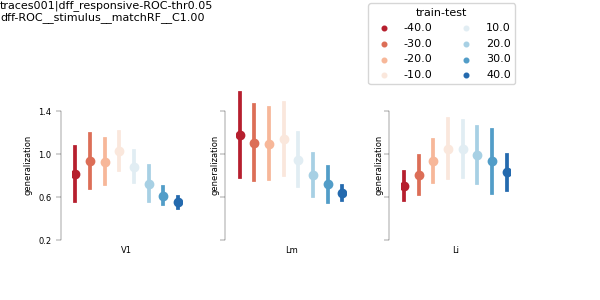

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls generalization_split_traintest__dff-ROC__stimulus__matchRF__C1.00


In [173]:
metric='generalization'
size_metric='train_test_diff'
multi_comp_test='fdr_bh'

curr_ncells=max_ncells

print(datameans_per_iter.groupby(['visual_area'])[metric].mean().round(3))
print(datameans_per_iter.groupby(['visual_area'])[metric].std().round(3))

plotd = datameans_per_iter[(datameans_per_iter.novel) 
                         & (datameans_per_iter['n_cells']==curr_ncells)].copy()

diff_palette = 'Greys' if size_metric=='train_test_abs' else 'RdBu'

#fig, axn = pl.subplots(1,2, figsize=(6.5,3), dpi=dpi, sharex=True, sharey=False)
fig, axn = pl.subplots(1, 3, figsize=(6,3), sharex=True,sharey=True)

# PLOT 2
for va, vg in plotd.groupby(['visual_area']):
    ax = axn[visual_areas.index(va)]
    sns.pointplot(x=size_metric, y=metric, hue=size_metric, data=vg, ax=ax, 
             palette=diff_palette, scale=0.8, 
              dodge=0.5, join=False, ci='sd', markers='o')
    ax.legend_.remove()
    ax.set_yticks(np.linspace(0.2, 1.4, 4))
    ax.set_ylim([0.2, 1.6])    
    ax.set_xlabel(va)
axn[-1].legend(bbox_to_anchor=(1.1, 1.), loc='lower right', title='train-test', markerscale=0.5, fontsize=8,
         ncol=2)

pl.tight_layout()
pl.subplots_adjust(left=0.12, right=0.85, wspace=0.5, top=0.7, bottom=0.2)

sns.despine(bottom=True, offset=8, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xticks([])

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname='generalization_split_traintest__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
#figname='genratio_meanbyiter_split_traintransform__%s_%s_%s2' % (dset_str, shuffle_str, errstr)

pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


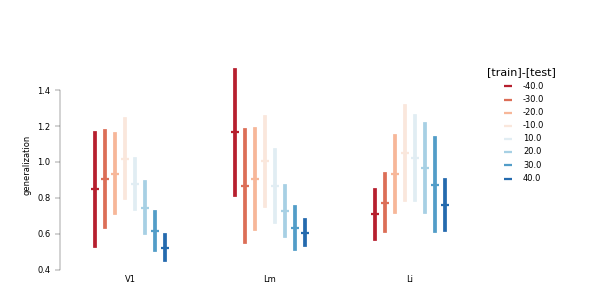

In [112]:
#fig, axn = pl.subplots(1,2, figsize=(6.5,3), dpi=dpi, sharex=True, sharey=False)
fig, ax = pl.subplots(figsize=(6,3))

# PLOT 2

sns.pointplot(x='visual_area', y=metric, data=plotd, ax=ax, 
           hue=size_metric, order=visual_areas, palette=diff_palette, scale=0.8, 
              dodge=0.5, join=False, ci='sd', markers='_')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
         title='[train]-[test]')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
sns.despine(bottom=True, trim=True)


In [53]:
import statsmodels.api as sm

In [54]:
iterdf.

SyntaxError: invalid syntax (<ipython-input-54-f61dbf0a6fe9>, line 1)

In [ ]:
if analysis_type=='by_fov':
    bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
    cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}


    fig, axn = pl.subplots(1,2, figsize=(6.5, 3), sharex=True, sharey=True)
    for ai, (is_intact, df) in enumerate(DF.groupby('intact')):
        ax=axn[ai]
        corr_str = 'Intact' if is_intact else 'No corrs.'
        ax.set_title(corr_str)
        sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
                hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
        sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
                hue='condition', order=visual_areas, palette=cond_colors,
                jitter=False, dodge=True, s=4)

        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
    pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85,
                      wspace=0.3)

    pplot.label_figure(fig, aggr_id)
    figname = 'intact_vs_indep'
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [167]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov'

<IPython.core.display.Javascript object>


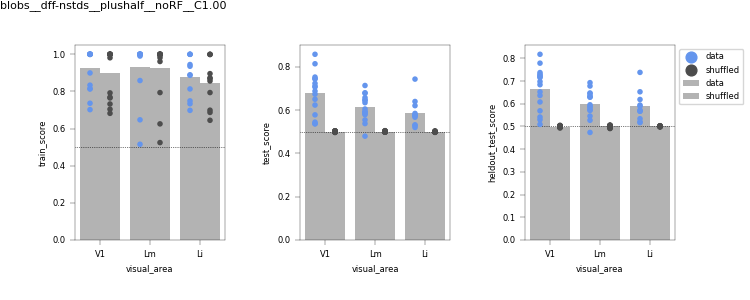

In [168]:
bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}

metric_list = ['train_score', 'test_score', 'heldout_test_score']

fig, axn = pl.subplots(1, len(metric_list), figsize=(2.5*len(metric_list), 3))
for ai, metric in enumerate(metric_list):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
    sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, palette=cond_colors,
            jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.85,
                  wspace=0.5)

pplot.label_figure(fig, aggr_id)
figname = 'aggr_performance_metrics'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [183]:
DF

,visual_area,datakey,condition,novel,train_transform,test_transform,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,n_trials,iteration,n_cells,intact
0,Li,20190422_JC076_fov1,data,False,10_20_30_40,10_20_30_40,0.011768,0.000475,0.526641,0.886592,0.011687,0.001365,0.016860,0.532917,1.0,4768.29,240.0,49.5,68.0,True
1,Li,20190422_JC076_fov1,data,False,10_20_30_50,10_20_30_50,0.011565,0.000462,0.536306,0.892078,0.009614,-0.001699,0.013870,0.537917,1.0,5212.13,240.0,49.5,68.0,True
2,Li,20190422_JC076_fov1,data,False,10_20_40_50,10_20_40_50,0.011347,0.000465,0.538179,0.895239,0.012811,0.002960,0.018483,0.543958,1.0,5011.99,240.0,49.5,68.0,True
3,Li,20190422_JC076_fov1,data,False,10_30_40_50,10_30_40_50,0.014093,0.000477,0.512409,0.872984,0.010969,0.000264,0.015826,0.523542,1.0,4847.80,240.0,49.5,68.0,True
4,Li,20190422_JC076_fov1,data,False,20_30_40_50,20_30_40_50,0.010543,0.000458,0.544619,0.900372,0.016351,0.008292,0.023590,0.552708,1.0,4803.09,240.0,49.5,68.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,V1,20191006_JC110_fov1,shuffled,False,10_20_30_40,10_20_30_40,0.005513,0.000721,0.496537,1.000000,0.009511,-0.000313,0.013722,0.493585,1.0,5074.57,264.0,49.5,221.0,True
626,V1,20191006_JC110_fov1,shuffled,False,10_20_30_50,10_20_30_50,0.005505,0.000725,0.507712,1.000000,0.012291,0.003762,0.017732,0.476226,1.0,5191.18,264.0,49.5,221.0,True
627,V1,20191006_JC110_fov1,shuffled,False,10_20_40_50,10_20_40_50,0.005547,0.000745,0.502377,1.000000,0.009419,-0.000424,0.013588,0.503962,1.0,5052.93,264.0,49.5,221.0,True
628,V1,20191006_JC110_fov1,shuffled,False,10_30_40_50,10_30_40_50,0.005608,0.000740,0.491905,1.000000,0.011515,0.002673,0.016613,0.510189,1.0,4996.48,264.0,49.5,221.0,True


<IPython.core.display.Javascript object>


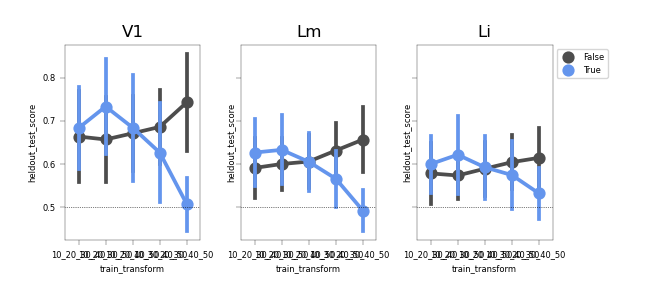

In [206]:
plotd = DF[DF.intact].copy()

keys = [True, False]
bw_cond_colors = dict((k, [0.7]*3) for k in keys)
#cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}
cond_colors = {keys[0]: 'cornflowerblue', keys[1]: [0.3]*3}

metric = 'heldout_test_score'
fig, axn = pl.subplots(1,3, figsize=(6.5, 3), sharex=True, sharey=True)
for vi, (va, df) in enumerate(DF.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va)
    sns.pointplot(x='train_transform', y=metric, data=df, ax=ax,
            hue='novel', ci='sd', palette=cond_colors)
#     sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
#             hue='condition', order=visual_areas, palette=cond_colors,
#             jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85,
                  wspace=0.3)

# pplot.label_figure(fig, aggr_id)
# figname = 'intact_vs_indep'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))